In [3]:
from __future__ import annotations
import numpy as np
import random
import copy
import importlib

from typing import Tuple, List
from numpy import array, zeros
from matplotlib import pyplot as plt

# from Big_Class import Big_Class  # already imported one NETfuncs is imported
from User_Variables import User_Variables  # already imported one NETfuncs is imported
from Network_Structure import Network_Structure  # already imported one NETfuncs is imported
from Big_Class import Big_Class
from Network_State import Network_State
from Networkx_Net import Networkx_Net
import matrix_functions, functions, statistics, plot_functions, solve, figure_plots, colors

## colors

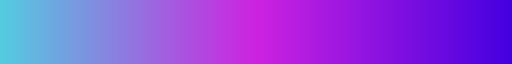

In [4]:
colors_lst, red, cmap = colors.color_scheme()
cmap

# Parameters

In [5]:
## Parameters

## task type
task_type='Iris_classification'

# ## task matrix X
M_values: np.ndarray = array([0])

## specify # of nodes
Nin: int = 4
extraNin: int = 0
Ninter: int = 0
Nout: int = 3
extraNout: int = 0

# resistance-pressure proportionality factor
gamma: np.ndarray = np.array([1.0])

## method to update resistances - physical property of the system
R_update: str = 'R_propto_dp'
# R_update: str = 'deltaR_propto_dp'
# R_update: str = 'deltaR_propto_Q'
# R_update: str = 'deltaR_propto_Power'
# R_vec_i = 2*array([1.9, 1., 0.85, 1.05, 0.9, 1., 0.85, 1.05, 0.9, 3., 0.85, 1.05, 0.9, 1., 0.85, 1.05, 1., 2.95, 0.55])
# R_vec_i = array([20, 1, 0.5, 10, 2, 1, 0.5, 10, 2, 10, 0.5, 1, 2, 1, 0.5, 1, 2, 1, 0.5])
R_vec_i = np.ones(Nin*Nout+Nin+Nout)

alpha: float = 0.05  # for network combine attempt
stay_sample: int = 2

# length of training dataset
iterations = 1200  # number of sampled of p

# measure accuracy every # steps
measure_accuracy_every = 5

supress_prints: bool = True  # whether to print information during training or not
bc_noise: float = 0.0  # noise to dual problem
use_p_tag: bool = True  # use 1 or 2 sampled pressures at every time step
include_Power: bool = False
lam: float = 0
    
random_state: int = 39  # random seed for train test shuffle
train_size: int = 30  # size of trainset, Sam and Nachi used 30, if all 150 are wanted then leave as None
    
access_interNodes: bool = False  # access and change pressure at interNodes (nodes between input and output) or not
noise_to_extra: bool = False  # add noise to extra outputs 

In [6]:
def network_build_given_stay_alpha(alpha: float) -> tuple():
    
    # initialize Variables
    Variabs = User_Variables(iterations,\
                             Nin, \
                             extraNin, \
                             Ninter, \
                             Nout, \
                             extraNout, \
                             gamma, \
                             R_update, \
                             use_p_tag, \
                             include_Power, lam, \
                             supress_prints, \
                             bc_noise, \
                             access_interNodes, \
                             task_type, \
                             measure_accuracy_every)
    
    Variabs.assign_alpha_vec(alpha)
    Variabs.create_dataset_and_targets(random_state=random_state, train_size=train_size)
    Variabs.create_noise_for_extras()
    BigClass = Big_Class(Variabs)
        
    # initialize Structure
    inInterOutGround_tuple = matrix_functions.build_input_output_and_ground(Variabs.Nin, Variabs.extraNin, Variabs.Ninter, 
                                                                            Variabs.Nout, Variabs.extraNout)
        
    
    Strctr = Network_Structure(inInterOutGround_tuple)
    Strctr.build_incidence()
    Strctr.build_edges()
    BigClass.add_Strctr(Strctr)  # add to big class
    
    # initialize State    
    State = Network_State(Variabs)
    State.initiate_resistances(BigClass, R_vec_i)
    State.initiate_accuracy_vec(BigClass, measure_accuracy_every)
    BigClass.add_State(State)  # add to big class
    
    return Variabs, Strctr, State, BigClass


def train_loop(Variabs, Strctr, State, BigClass, stay_sample): 
    State.accuracy = 1/3 
    for l in range(Variabs.iterations):
        if l % np.shape(Variabs.X_train)[0] == 0 and Variabs.task_type == 'Iris_classification':
            State.assign_targets_Iris(BigClass)
        
        k = (l//stay_sample)*2 + l%2

        # draw input and desired outputs from dataset
        if not((l+1) % 4):  # add noise only at i=3 etc.
            State.draw_p_in_and_desired(Variabs, k, noise_to_extra=False)  # add noise to extra nodes every 2nd iteration
            State.solve_flow_given_problem(BigClass, "measure", noise_to_extra=False)  # measure and don't change resistances
        else:  # dont add noise to extra nodes
            State.draw_p_in_and_desired(Variabs, k)
            State.solve_flow_given_problem(BigClass, "measure")

        if not l % 2:  # even iterations, take another sampled pressure and measure again
            pass
        else:  # odd iterations, go to dual problem and update resistances
            State.t += 1
            # print('time=', State.t)
            State.calc_loss(BigClass)
            loss_mean = np.mean(np.abs(State.loss), axis=1)
            if State.accuracy>0.92:
                State.loss_in_t[-1] = array([[0, 0, 0],[0, 0, 0]])
            State.update_input_dual(BigClass)
            State.update_output_dual(BigClass)
            State.solve_flow_given_problem(BigClass, "dual", access_inters=False)  # measure and don't change resistances
            State.update_Rs(BigClass)
            
        # measure accuracy
        if l % Variabs.measure_accuracy_every == 0 \
           and l//Variabs.measure_accuracy_every<len(State.accuracy_in_t):
            if l==0:
                State.accuracy_in_t[l] = State.accuracy
                State.t_for_accuracy[l//Variabs.measure_accuracy_every] = State.t 
            else:
                State.calculate_accuracy_testset(BigClass)
                State.accuracy_in_t[l//Variabs.measure_accuracy_every] = State.accuracy 
                State.t_for_accuracy[l//Variabs.measure_accuracy_every] = State.t 
    return State

# Loop stay

In [7]:
alpha_vec = array([0.1])
random_state_vec = array([37, 38, 40, 41, 42, 43, 44, 45])
method_vec = array(['R_propto_dp', 'deltaR_propto_dp', 'deltaR_propto_Q', 'deltaR_propto_Power'])
accuracy_size = int(np.floor(iterations/measure_accuracy_every))
accuracy_in_t_mat = np.zeros([np.shape(random_state_vec)[0], accuracy_size])

for i, R_update in enumerate(method_vec):
    print('R_update', R_update)
    for j, random_state in enumerate(random_state_vec):
        print('stay', stay_sample)
        print('alpha', alpha_vec[0])
        Variabs, Strctr, State, BigClass = network_build_given_stay_alpha(alpha)
        print('starting train loop')
        State = train_loop(Variabs, Strctr, State, BigClass, stay_sample)
        
        plot_functions.plot_importants(State, Variabs, State.desired_in_t, include_network=True)
        plot_functions.plot_accuracy(State.t, State.t_for_accuracy, State.accuracy_in_t, np.shape(Variabs.dataset)[0])
        plt.show()
        
        accuracy_in_t_mat[j] = State.accuracy_in_t
        
    # save_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/'
    save_folder_prelim = 'C:/Users/roiee/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/'

    np.save(save_folder_prelim + str(R_update) + 't.npy', State.t)
    np.save(save_folder_prelim + str(R_update) + 't_for_accuracy.npy', State.t_for_accuracy)
    np.save(save_folder_prelim + str(R_update) + 'accuracy_in_t', accuracy_in_t_mat)
    np.save(save_folder_prelim + str(R_update) + 'dataset_shape', np.shape(Variabs.X_train))

R_update R_propto_dp
stay 2
alpha 0.1


TypeError: __init__() got an unexpected keyword argument 'sparse_output'

In [9]:
save_folder_prelim = 'C:/Users/roiee/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/'
np.save(save_folder_prelim + str(R_update) + 'dataset_shape', np.array([30, 4]))

In [ ]:
State.accuracy_in_t

In [ ]:
np.save(save_folder_prelim + 'accuracy_in_t', State.accuracy_in_t)

In [ ]:
State.targets_mat

In [ ]:
np.shape(accuracy_in_t_mat)

In [ ]:
# save_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/'

# np.save(save_folder_prelim + 't.npy', State.t)
# np.save(save_folder_prelim + 't_for_accuracy.npy', State.t_for_accuracy)
# np.save(save_folder_prelim + 'accuracy_in_t', State.accuracy_in_t)
# np.save(save_folder_prelim + 'dataset_shape', np.shape(Variabs.X_train))